# DSP in Python

1. Discrete signal and Discrete Fourier transform (DFT)
2. Short-time Fourier transform (STFT)

In [4]:
import numpy as np
import pylab as plt
import scipy.signal as sg
import pandas as pd
import sounddevice as sd
from scipy.io.wavfile import read as read_wav

plt.rcParams["figure.figsize"] = (8,2)
plt.rcParams["figure.dpi"] = 150

## 1. Discrete signal and Discrete Fourier transform


### 500 Hz example

$x(t) = sin(2\pi\cdot500\cdot t)$

$x[n] = x(t_n) =x(n\Delta t) = x(n/f_s) = sin(2\pi\cdot500\cdot n/f_s)$

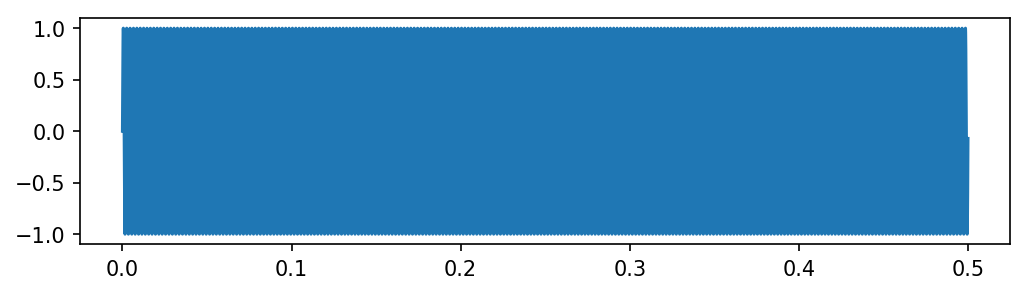

In [5]:
fs = 44100
n_samples = fs//2
n = np.arange(n_samples)

x = np.sin(2*np.pi*500*n/fs)
sd.play(x, fs) 
plt.plot(n/fs, x)

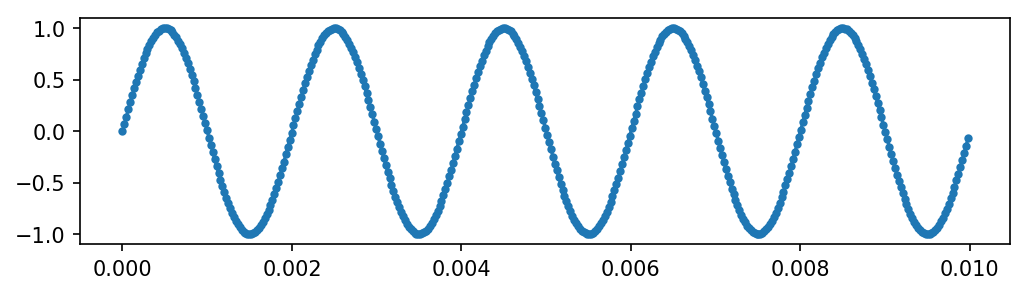

In [6]:
plt.figure(figsize=(8, 2), dpi=150) 
plt.plot(n[:fs//100]/fs, x[:fs//100], '.-')

Discrete Fourier transform:

$X[k] = \sum\limits_{n=0}^{N-1}x[n]e^{-jn\cdot2\pi k/N}$

Inverse transform:

$x[n] = \frac{1}{N}\sum\limits_{k=0}^{N-1}X[k]e^{jn\cdot2\pi k/N}$

50 Hz noise signal ($f_s = 44100$, $N=22050$):

$x[n] = sin(2\pi\cdot500\cdot n/f_s) = sin(2\pi n\cdot\frac{500 N}{fs} /N) = -\frac{j}{2}e^{jn\cdot2\pi \frac{500 N}{fs}/N}+\frac{j}{2}e^{jn\cdot2\pi (N-\frac{500 N}{fs})/N}$

$X[\frac{500 N}{fs}] = X[250]=-\frac{jN}{2} = -j11025$

$X[N-\frac{500 N}{fs}] = X[21800] = -\frac{jN}{2} = +j11025$ 


DFT implementation (`numpy.fft` or `scipy.fftpack`)


X[250] = -0-11025j
X[21800] = -0+11025j
sum(|X[other]|) = 22050


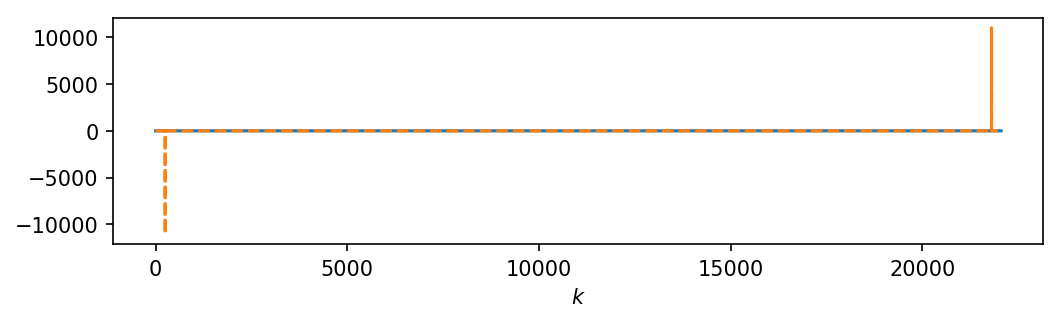

In [7]:
xf = np.fft.fft(x)
plt.plot(np.real(xf)), plt.plot(np.imag(xf), '--'), plt.xlabel('$k$') 
print('X[250] = {:.0f}'.format(xf[250]))
print('X[21800] = {:.0f}'.format(xf[21800]))
print('sum(|X[other]|) = {:.0f}'.format(np.abs(xf[~np.isin(n, [25, 225])]).sum()))

About frequencies:

$e^{jn\cdot2\pi k/N} = e^{2\pi j\cdot \frac{n}{f_s}\cdot \frac{kf_s}{N}} = e^{2\pi j\cdot t_k\cdot f_k}~~~~~~~~~~~~~~~~~x[n] = \frac{1}{N}\sum\limits_{k=0}^{N-1}X[k]e^{jn\cdot2\pi k/N}$

$t_n = n\Delta t = \frac{n}{f_s}~~~~~~~~f_k = \frac{kf_s}{N}$

(0, 1000)

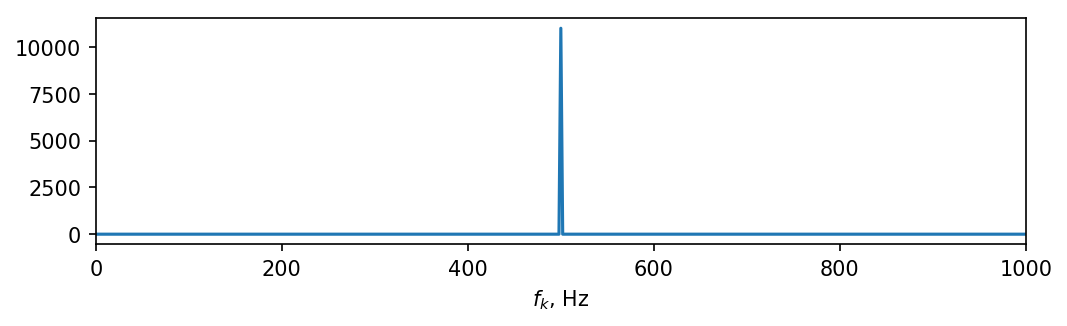

In [8]:
k = np.arange(n_samples)
fk = k*fs/n_samples
plt.plot(fk, np.abs(xf)), 
# plt.plot(fk, np.imag(xf), '--')
plt.xlabel('$f_k$, Hz')
plt.xlim(0, 1000) 

Periodicity:

$X[k] = \sum\limits_{n=0}^{N-1}x[n]e^{-jn\cdot2\pi k/N}$


$X[-k] = X[N-k]$


Text(0.5,0,'$f_k$, Hz')

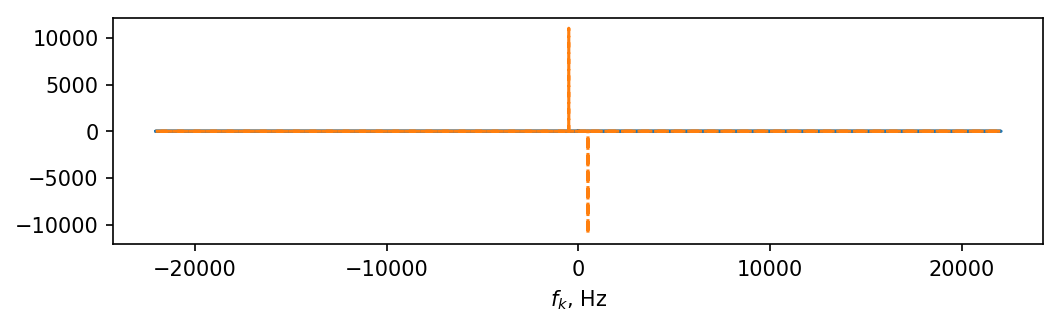

In [9]:
xf = np.fft.fft(x)
# freq = np.concatenate([np.arange(n_samples//2), np.arange(-n_samples//2, 0)])*fs/n_samples
freq = np.fft.fftfreq(n_samples, d=1/fs) 

plt.plot(freq, np.real(xf)), 
plt.plot(freq, np.imag(xf), '--')
plt.xlabel('$f_k$, Hz')
# plt.xlim(-1000, 1000)

Discrete Fourier transform for real-valued signal:

$X[k] = \sum\limits_{n=0}^{N-1}x[n]e^{-jn\cdot2\pi k/N}$


$k' = N-k; ~~~ k=N-k'$

$X[N-k'] = \sum\limits_{n=0}^{N-1}x[n]e^{jn\cdot2\pi k'/N} = X^*[k']$

Text(0.5,0,'$f_k$, Hz')

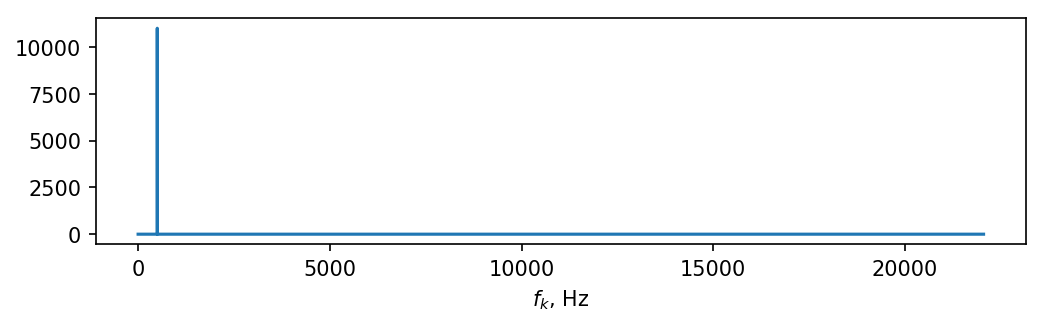

In [10]:
xf = np.fft.rfft(x)
freq = np.fft.rfftfreq(n_samples, d=1/fs) 

plt.plot(freq, np.abs(xf)), 
# plt.plot(freq, np.imag(xf), '--')
plt.xlabel('$f_k$, Hz')

### 900Hz + 500Hz example



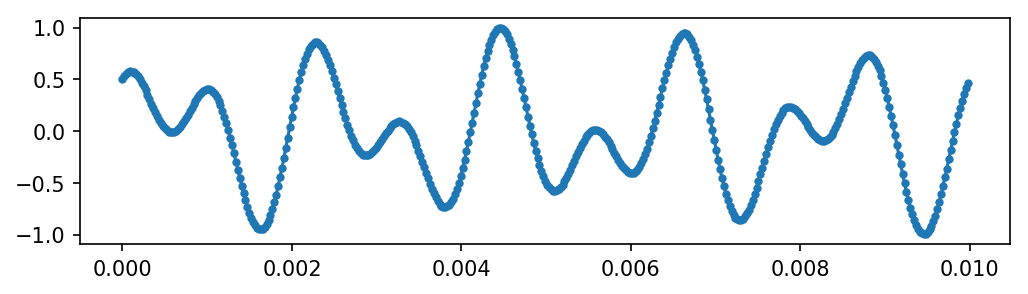

In [11]:
x = np.cos(2*np.pi*900*n/fs)/2 + np.sin(2*np.pi*500*n/fs)/2
sd.play(x, fs)
plt.plot(n[:fs//100]/fs, x[:fs//100], '.-')

(0, 1000)

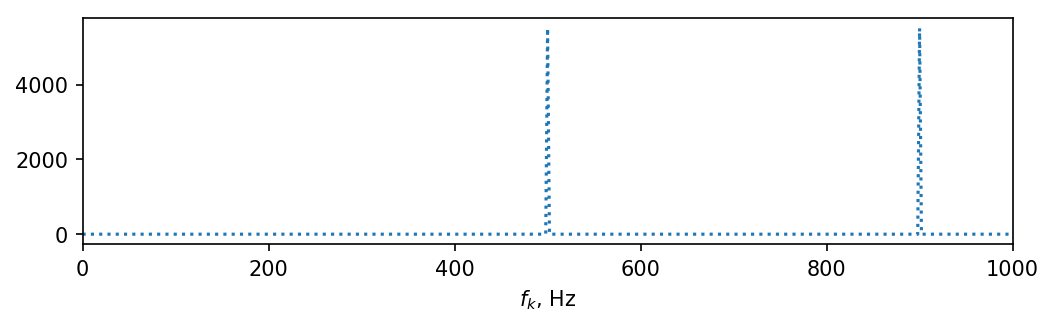

In [12]:
xf = np.fft.rfft(x)
freq = np.fft.rfftfreq(n_samples, d=1/fs) 

# plt.plot(freq, xf.real), 
# plt.plot(freq, xf.imag, '--')
plt.plot(freq, np.abs(xf), ':')
plt.xlabel('$f_k$, Hz')
plt.xlim(0, 1000)

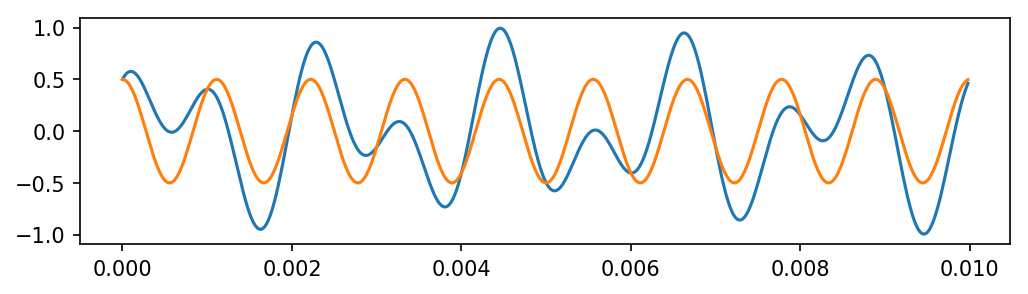

In [13]:
xf[freq > 1000] = 0
xf[freq < 800] = 0
x_clear = np.fft.irfft(xf) 

plt.plot(n[:fs//100]/fs, x[:fs//100])
plt.plot(n[:fs//100]/fs, x_clear[:fs//100])

sd.play(x_clear, fs)

In [14]:
import os
def load_sample(label, sample_number, play=False):
    data_dir = r'C:\Users\cbi\Desktop\old2\speech_commands_v0.01'
    samples_dir = os.path.join(data_dir, label)
    sample_name = os.listdir(samples_dir)[sample_number]
    sample_path = os.path.join(samples_dir, sample_name)
    fs, x = read_wav(sample_path)
    x = (x-x.mean())/x.std()
    x_zero_padded = np.zeros(fs)
    x_zero_padded[:min(fs, len(x))] = x[:fs]
    if play: sd.play(x_zero_padded, fs)
    return x_zero_padded, fs


x, fs = load_sample('cat', 45 , play=True)
t = np.arange(len(x))/fs
print('fs = {}Hz\nx[n] = {}'.format(fs, x))

fs = 16000Hz
x[n] = [ 0.00260878 -0.00011104 -0.00119896 ...  0.04993365  0.03633455
  0.03470266]


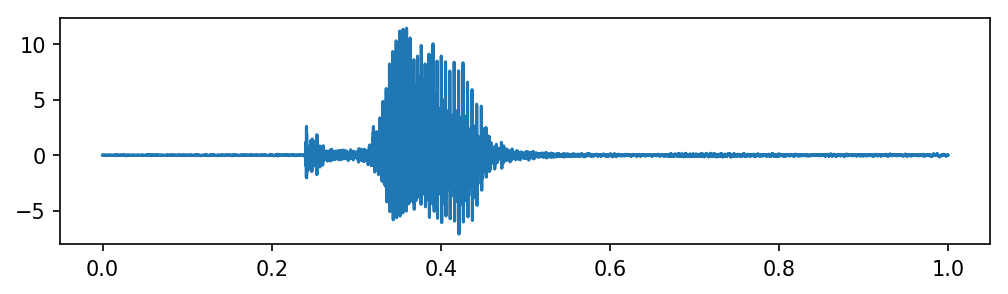

In [15]:
plt.plot(t, x)

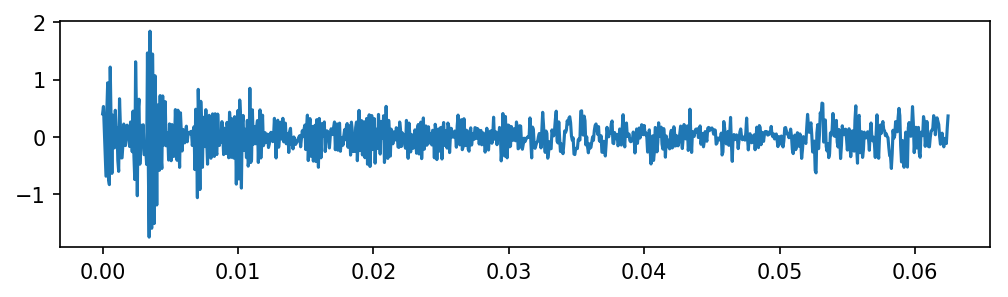

In [16]:
nperseg = 1000
start = int(0.25*fs)
x_seg = x[start:start + nperseg]
plt.plot(np.arange(nperseg)/fs, x_seg)

Text(0.5,0,'f, Hz')

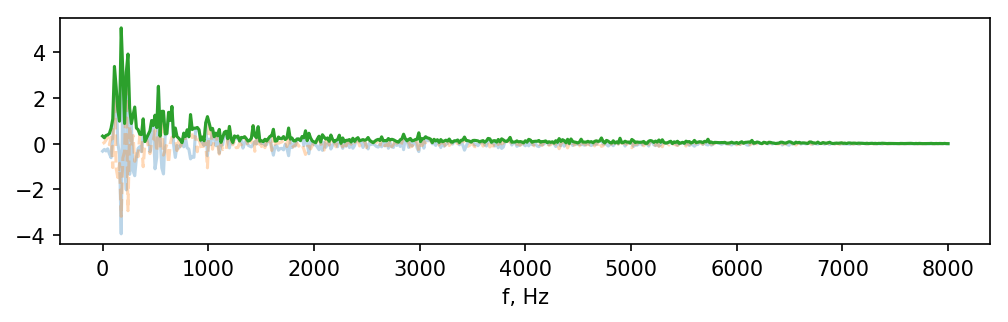

In [17]:
start = int(0.0*fs)
x_seg = x[start:start + nperseg]
seg_ind = np.arange(start, start + nperseg)

xf = np.fft.rfft(x_seg)
freq = np.fft.rfftfreq(nperseg, d=1/fs) 

plt.plot(freq, xf.real, alpha=0.3), 
plt.plot(freq, xf.imag, '--', alpha=0.3)
plt.plot(freq, np.abs(xf))
plt.xlabel('f, Hz')

# 2. Short-time Fourier transform (STFT)

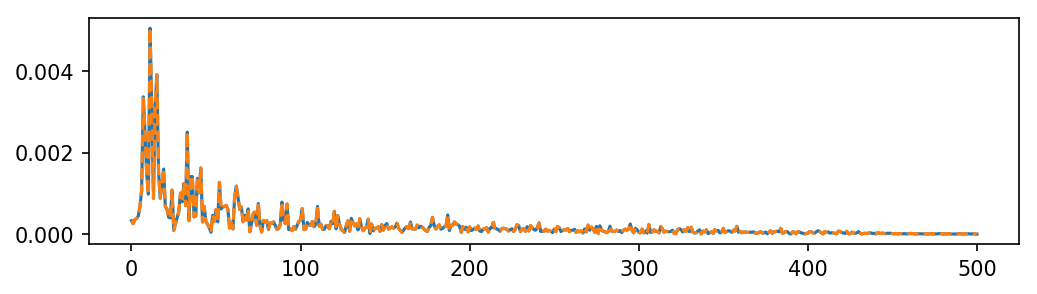

In [18]:
f, t, xft = sg.stft(x, fs, nperseg=nperseg, window=np.ones(nperseg), padded=False, boundary=None, noverlap=int(nperseg*0.9))
plt.plot(np.abs(xft[:, 0]))
plt.plot(np.abs(xf/nperseg), '--')    

Text(0.5,0,'Time [sec]')

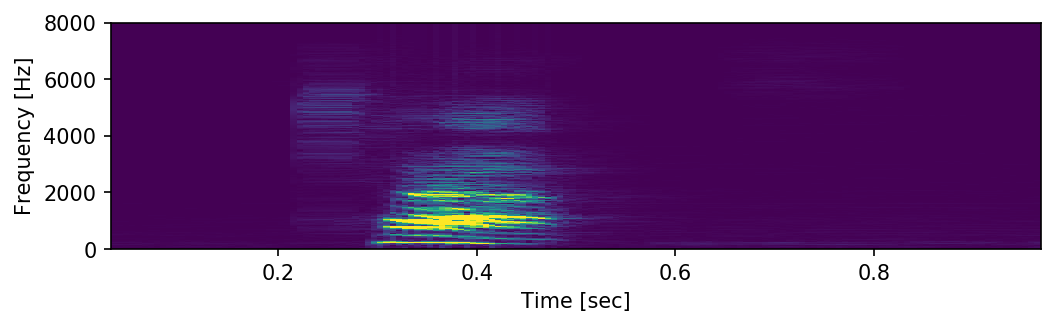

In [19]:
plt.pcolormesh(t, f, np.abs(xft), vmax=0.2)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
# plt.ylim(0, 3000)

Text(0.5,0,'Time [sec]')

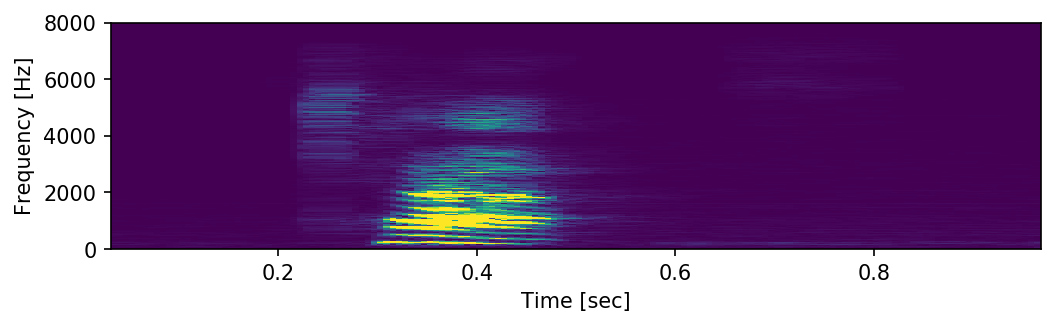

In [20]:
nperseg=1000
f, t, xft = sg.spectrogram(x, fs, scaling='spectrum', nperseg=nperseg, noverlap=int(nperseg*0.9))
plt.pcolormesh(t, f, xft**0.5, vmax=0.2)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

Text(0.5,0,'Time [sec]')

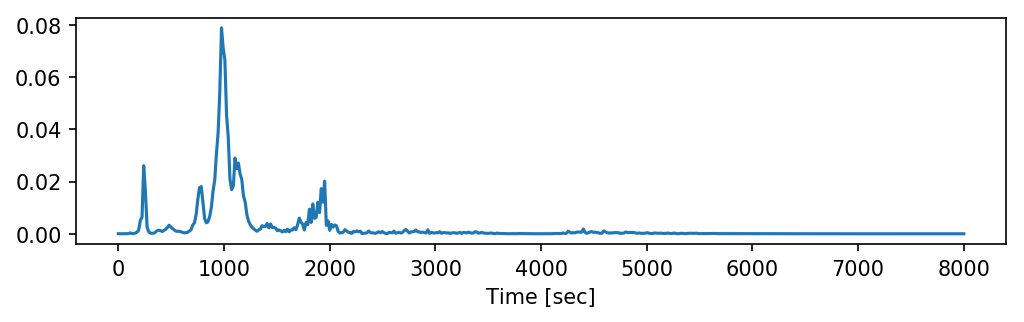

In [21]:
alpha_pow = xft.mean(1)
plt.plot(f, alpha_pow)
plt.xlabel('Time [sec]')

Text(0.5,0,'Freq, Hz')

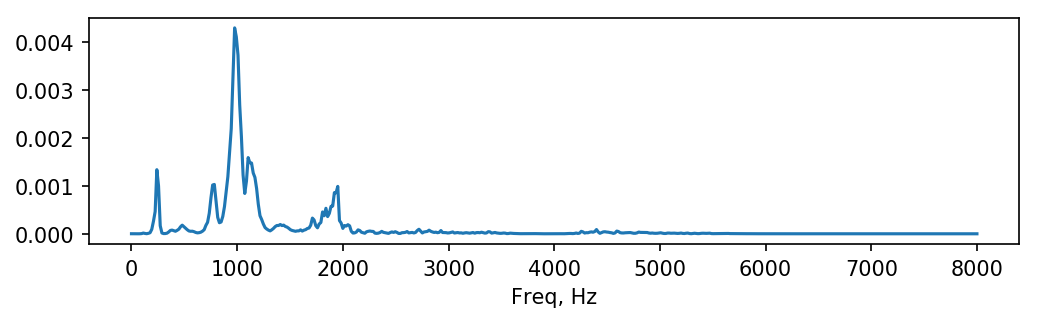

In [22]:
freq, pxx = sg.welch(x, fs, nperseg=nperseg, noverlap=int(nperseg*0.9))
plt.plot(freq, pxx)
plt.xlabel('Freq, Hz') 

Text(0.5,0,'Freq., Hz')

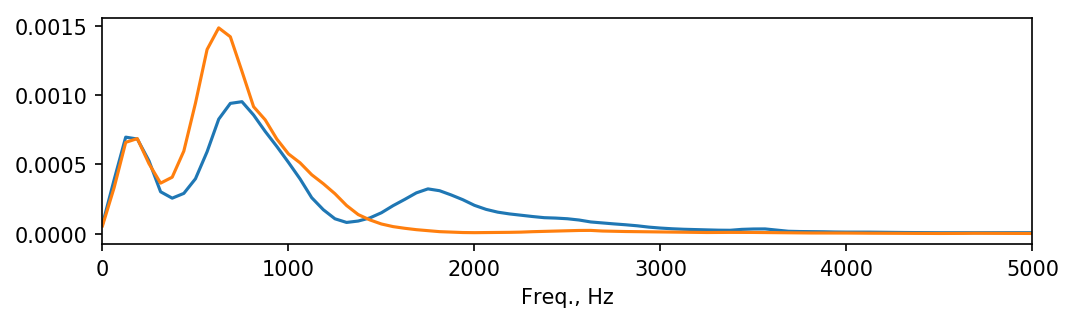

In [28]:
labels = ['cat', 'dog']
mean_spectra = []
for label in labels:
    spectra = []
    for k in range(500):
        x, fs = load_sample(label, k)
        freq, spectrum = sg.welch(x, fs)
        spectra.append(spectrum)
    mean_spectrum = np.mean(spectra, 0)
    std_spectrum = np.std(spectra, 0)
    plt.plot(freq, mean_spectrum)
#     plt.fill_between(freq, mean_spectrum-std_spectrum, mean_spectrum+std_spectrum, alpha=0.5)
    mean_spectra.append(mean_spectrum)
mean_spectra = np.array(mean_spectra)
plt.xlim(0, 5000)
plt.xlabel('Freq., Hz')

Text(0.5,0,'Freq., Hz')

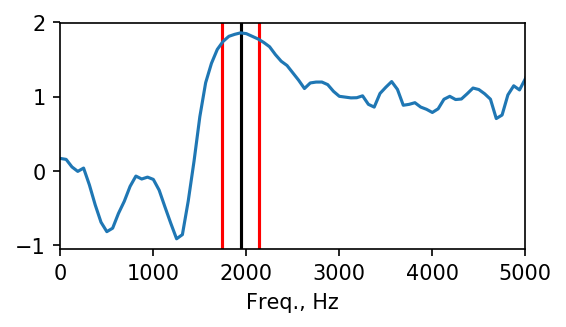

In [29]:
fig, axes = plt.subplots(1, figsize=(4,2), dpi=150, sharex=True, sharey=True)
spectra_diff = 2*(mean_spectra[0]-mean_spectra[1])/(mean_spectra[0]+mean_spectra[1])
main_freq = freq[np.argmax(np.abs(spectra_diff))]
sign = np.sign(spectra_diff[np.argmax(np.abs(spectra_diff))])
band = np.array([-1, 1])*200 + main_freq
plt.axvline(main_freq, color='k')
[plt.axvline(f, color='r') for f in band]
plt.plot(freq, spectra_diff)
plt.xlim(0, 5000)
plt.xlabel('Freq., Hz')

In [30]:
freq_slice = (freq>band[0]) & (freq<band[1])
threshold = np.exp(np.log(mean_spectra[:, freq_slice]).mean())
print(threshold)

5.16250472895665e-05


In [31]:
from time import sleep
print('{:12s} {:12s} {:12s}'.format('prediction', 'actual', 'error'))
for label in labels:
    for k in range(17, 24):
        x, fs = load_sample(label, k)
        freq, spectrum = sg.welch(x, fs)
        label_n = (spectrum[freq_slice].mean() < threshold)
        if sign < 0: label_n = ~label_n
        prediction = labels[int(label_n)]
        print('{:12s} {:12s} {}'.format(prediction, label, '' if prediction==label else 'x'))
        sd.play(x, fs), sleep(1.5)

prediction   actual       error       
cat          cat          
cat          cat          
cat          cat          
dog          cat          x
cat          cat          
cat          cat          
cat          cat          
dog          dog          
dog          dog          
dog          dog          
cat          dog          x
dog          dog          
dog          dog          
dog          dog          
